In [1]:
# set variables and file paths

model_name = "meta-llama/Llama-3.3-70B-Instruct"
output_path = "output/Llama_3.3_70B_zs_reddit_2Labels_val.csv"

# **Llama-3.3-70B-Instruct**

## **Validate Zero Shot Classification agains P & C & E and on Debagree Test Set**




In [2]:
# install packages
!pip install -U bitsandbytes
!pip install -U transformers
!pip install -U accelerate
!pip install -U peft
!pip install -U trl
!pip install pyarrow==18.1.0
!pip install evaluate
!pip install datasets 

  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
Using cached transformers-4.51.3-py3-none-any.whl (10.4 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transformers-4.48.3:
      Successfully uninstalled transformers-4.48.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
adapters 1.1.1 requires transformers~=4.48.3, but you have transformers 4.51.3 which is incompatible.


In [3]:
# import packages

import numpy as np
import pandas as pd
import os
import random
import evaluate
import functools # ??
from tqdm import tqdm
import bitsandbytes as bnb
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import is_bf16_supported

from datasets import Dataset, DatasetDict
from peft import LoraConfig, PeftConfig, prepare_model_for_kbit_training, get_peft_model

from trl import SFTTrainer
from trl import setup_chat_format

import transformers
from transformers import (AutoModelForCausalLM,
                          AutoModelForSequenceClassification,
                        AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                            Trainer,
                            DataCollatorWithPadding,
                          pipeline, 
                          logging)

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix,
                            f1_score, balanced_accuracy_score)
from sklearn.metrics import precision_recall_fscore_support


import ast
from huggingface_hub import login
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:

print(torch.cuda.is_available())
torch.cuda.empty_cache()

# check GPU's capacity for quantization
print(torch.cuda.get_device_name(0))
print(is_bf16_supported())


True
NVIDIA H100 80GB HBM3 MIG 3g.40gb
True


## **Authenticate for Hugging Face**

In [5]:
os.getcwd()

'/home/jovyan/llama_final/Validation'

In [6]:
# Hugging face access

with open("../../login/hf_key.txt", 'r') as f: 
    HF_TOKEN = str(f.read())
    
login(token = HF_TOKEN)

## **Data**

In [7]:
# loading the data
import pandas as pd
data = pd.read_csv("../../data/new_preprocessing/debagree_new_preprocessing_com_rep.csv")
data = data[["label", "body_parent", "body_child", "msg_id_parent", "msg_id_child", "subreddit", "datetime", "exact_time"]].sort_values(by = "exact_time").reset_index(drop = True)

# keep integer labels
data['target'] = data['label']

# for readability, recode labels
int_to_label = {2: "agree", 1 : "neutral", 0 : "disagree"}
data.replace({"label": int_to_label}, inplace = True)

data

,label,body_parent,body_child,msg_id_parent,msg_id_child,subreddit,datetime,exact_time,target
0,neutral,"I live in rural Saskatchewan, Canada. We have ...",I'm in NE USA we've had 3 in two years...all e...,cnddov1,cndj2gv,climate,03/01/2015 23:18,1420327135,1
1,neutral,"I live in rural Saskatchewan, Canada. We have ...",One hundred year flood just means a one in one...,cnddov1,cndkpy7,climate,04/01/2015 00:10,1420330231,1
2,neutral,Convince her of what? That it's happening or t...,That anthropocentric climate change is actuall...,cndnlrd,cndnsxt,climate,04/01/2015 01:45,1420335952,1
3,disagree,I think this prediction is about as valid as s...,It's January. Literally no one said it would b...,cndl5x4,cndybsy,climate,04/01/2015 08:01,1420358465,0
4,disagree,"Mann hasn't been honest in decades, so I'm cur...",There have been a dozen re-constructions of Ma...,cne462t,cne89ej,climate,04/01/2015 17:45,1420393544,0
...,...,...,...,...,...,...,...,...,...
42838,neutral,Not trying to spark an argument but a legitima...,Keeping in mind that the Palestinians killed m...,gyo197v,gyotff1,Republican,19/05/2021 12:36,1621427788,1
42839,agree,Y'all saw Guilianis hail Mary right? Get his s...,"Same I want these assholes in jail, full stop....",gynfsu4,gyp3u39,democrats,19/05/2021 13:56,1621432578,2
42840,agree,Why don't I see ads holding Republicans accoun...,"Yeah, I agree with the goal of this post but n...",gyn6nzm,gyp5vzw,democrats,19/05/2021 14:11,1621433471,2
42841,agree,How about ... no? This is strange. Community o...,"I know, it feels strange too. We wouldn't hold...",gyp71o7,gyp7en6,BlackLivesMatter,19/05/2021 14:21,1621434116,2


In [8]:
# Split the DataFrame
train_size = 0.8
eval_size = 0.1

# Determine splitting indexes (ordered by time)
train_end = int(train_size * len(data))
eval_end = train_end + int(eval_size * len(data))

# Split the data
X_train = data[:train_end]
X_eval = data[train_end:eval_end]
X_test = data[eval_end:]

In [9]:
X_test

,label,body_parent,body_child,msg_id_parent,msg_id_child,subreddit,datetime,exact_time,target
38558,disagree,How about some stimulus checks and a decent st...,President Biden is actually doing his job to p...,gn83g77,gn88sye,democrats,13/02/2021 15:30,1613230254,0
38559,agree,It's so nice having a FLOTUS who's facial expr...,Melanoma's squinty cat face always looked to m...,gn5a3mu,gn8d9a0,democrats,13/02/2021 15:49,1613231397,2
38560,disagree,Because Mitch McConnell indicated he's voting ...,I think it's worth it because the more we air ...,gn89k88,gn8e765,democrats,13/02/2021 15:53,1613231638,0
38561,disagree,How about some stimulus checks and a decent st...,"You get this was an executive action, not legi...",gn83g77,gn8gusu,democrats,13/02/2021 16:08,1613232527,0
38562,disagree,Satire feels appropriate. I'd like one dose of...,Are you saying they didn't know or understand ...,gn8fdp8,gn8je2a,Brexit,13/02/2021 16:19,1613233181,0
...,...,...,...,...,...,...,...,...,...
42838,neutral,Not trying to spark an argument but a legitima...,Keeping in mind that the Palestinians killed m...,gyo197v,gyotff1,Republican,19/05/2021 12:36,1621427788,1
42839,agree,Y'all saw Guilianis hail Mary right? Get his s...,"Same I want these assholes in jail, full stop....",gynfsu4,gyp3u39,democrats,19/05/2021 13:56,1621432578,2
42840,agree,Why don't I see ads holding Republicans accoun...,"Yeah, I agree with the goal of this post but n...",gyn6nzm,gyp5vzw,democrats,19/05/2021 14:11,1621433471,2
42841,agree,How about ... no? This is strange. Community o...,"I know, it feels strange too. We wouldn't hold...",gyp71o7,gyp7en6,BlackLivesMatter,19/05/2021 14:21,1621434116,2


In [10]:
val_data = pd.read_csv("data/majority_validation.csv")
val_data

,submission_id,msg_id_parent,msg_id_child,submission_text,body_parent,body_child,subreddit,label_e,label_c,label_p,majority_label
0,8we2i8,e2gbshk,e2go5cs,So walkaway has gone viral whatever that means...,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,Ask_Politics,disagree,no_disagreement,disagree,disagree
1,17p478l,k8h1qxn,k8ivjmx,Question in a state like Mississippi thats oft...,You talk like Mississippi has the same infrast...,"Wow lol, was it that obvious that I'm from New...",Askpolitics,no_disagreement,disagree,no_disagreement,no_disagreement
2,181o366,kaf8us2,kahj2cn,"In the United States, there is a lot about wha...",We need to read more classic literature,May I ask what you consider the classics?,PoliticalDebate,no_disagreement,no_disagreement,no_disagreement,no_disagreement
3,18rqy2g,kf37doz,kf54umb,Federal Revenue FY 2022 Budget -- Income Taxe...,Everything the government does that isnt makin...,So you would immediately remove Medicare and S...,PoliticalDebate,no_disagreement,disagree,disagree,disagree
4,4dgyfc,d1qsqkm,d1r17xo,"In an appearance on CNN's New Day, Jeff Weaver...",Funny math It's still math. It's unlikely that...,Weaver is playing cute with the super delegate...,PoliticalDiscussion,no_disagreement,disagree,no_disagreement,no_disagreement
5,18fxb9q,kd28j8o,kdb3j9u,Milei has promised shock therapy as a way to a...,Why would he reduce capital expenditures or bl...,Argentinian government debt is basically worth...,PoliticalDiscussion,no_disagreement,no_disagreement,disagree,no_disagreement
6,"""xqo2u""","""c5or5ik""","""c5p0n4r""","""Truth be told, it's not any individual's faul...","""You folks will enjoy r.politics much more whe...","""Same thing is on - it takes you an hour to g...","""politics""",no_disagreement,no_disagreement,no_disagreement,no_disagreement
7,17phvl2,k87wrac,k89o4tn,There's a lot going on in the right now that h...,"IMHO Republicans will gain seats in the House,...",Republicans are showing they can govern. I don...,PoliticalDebate,disagree,disagree,disagree,disagree
8,"""2p7xdk""","""cmu9elu""","""cmuk9pu""","""I'm sure you could have always found 20 of th...","""The American Right has perpetrated this, thro...","""Play spot the Fasci next time you're looking ...","""politics""",no_disagreement,no_disagreement,disagree,no_disagreement
9,1ov3n2,ccw1rty,ccw2pn9,This fascinating article about a recent Yale s...,I don't find this particularly disturbing and ...,To add to what you said and expand on the arti...,NeutralPolitics,no_disagreement,no_disagreement,no_disagreement,no_disagreement


### Shares

In [7]:
val_data['majority_label'].value_counts()

majority_label
no_disagreement    39
disagree           21
Name: count, dtype: int64

## **Load the Model**



### Quantization for QLoRA

In [11]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4 bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

### **Load the Model**

* AutoModelForCausalLM 

In [12]:
torch.cuda.empty_cache()

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config = quantization_config
)

model

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1016, please report a bug to PyTorch. 

## **Tokenizer**

### Since LLAMA3 pre-training doesn't have EOS token
* Set the pad_token_id to eos_token_id
* Set pad token ot eos_token

In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space = True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

### Update Model Configurations

In [18]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_pt = 1

NameError: name 'model' is not defined

## **Generate Prompts**

In [15]:
# make text

def create_training_data(data, nr_labels):

    result = []

    for idx, row in data.iterrows():

        if nr_labels == 2:
            system_prompt = """You are a classification chatbot. Analyze a Reddit comment and its reply. Determine if the reply explicitly and unambiguously disagrees with the comment. Respond with 'disagree' for clear disagreement or 'no_disagreement' if the reply adds information, qualifies the statement, offers an alternative perspective, or leaves any doubt about disagreement. Your response must strictly be 'disagree' or 'no_disagreement'."""
        elif nr_labels == 3:
            system_prompt = """You are a classification chatbot. Analyze a Reddit comment and its reply. Determine whether the reply explicitly and unambiguously agrees, disagrees, or remains neutral toward the comment. Respond with "agree" for clear agreement, "disagree" for clear disagreement, or "neutral" if the reply adds information, qualifies the statement, offers an alternative perspective, is vague, off-topic, or leaves any doubt about agreement or disagreement. Your response must strictly be one of: "agree", "disagree", or "neutral"."""
        else:
            print("Invalid nr. of labels. Please enter 2 or 3.")
        
        comment = row["body_parent"]
        reply = row["body_child"]
        #label = row["label"]
        #target = row["target"]
        
        comment_id = row["msg_id_parent"]
        reply_id = row["msg_id_child"]
        subreddit = row["subreddit"]
        
        result.append({'system_prompt' : system_prompt, 'comment' : comment, 'reply': reply, 'msg_id_parent' : comment_id, 'msg_id_child' : reply_id, 'subreddit' : subreddit})
    
    return result

# save data
df_2 = pd.DataFrame(create_training_data(data_2, 2))
df_2

df_3 = pd.DataFrame(create_training_data(data_3, 3))
df_3

X_test = pd.DataFrame(create_training_data(data_2, 2))



,system_prompt,comment,reply,msg_id_parent,msg_id_child,subreddit
0,You are a classification chatbot. Analyze a Re...,All I can tell you is this as an American in h...,"Nailed it. It's a creepy, obvious propaganda w...",ca6pz16,ca6tzd6,NeutralPolitics
1,You are a classification chatbot. Analyze a Re...,WALLACE In the 2008 Heller case the court rule...,The Second Amendment of the United States Cons...,d8zmtyz,d8zvhsy,NeutralPolitics
2,You are a classification chatbot. Analyze a Re...,Your priorities are incredibly out of whack. 1...,I meant as a leader what has he done to lead u...,g3seqc0,g3sfjgi,Askpolitics
3,You are a classification chatbot. Analyze a Re...,"Speaking from a Dem perspective, here's a list...",Illinois Dem voter here. It's almost a shame t...,d6030t4,d60514s,PoliticalDiscussion
4,You are a classification chatbot. Analyze a Re...,The nominally communist regimes called themsel...,The nominally communist regimes called themse...,ci1ityc,ci1n1c7,Ask_Politics
5,You are a classification chatbot. Analyze a Re...,"The grievances are, definitely, legitimate. Mi...",Minority groups are much more likely to be ch...,cxj9x28,cxjv7jn,NeutralPolitics
6,You are a classification chatbot. Analyze a Re...,"""If Kavanaugh has a shred of decency or shame ...","""The GOP has no decency or shame anymore.""","""e6qoi50""","""e6qorit""","""politics"""
7,You are a classification chatbot. Analyze a Re...,"""The American Right has perpetrated this, thro...","""Play spot the Fasci next time you're looking ...","""cmu9elu""","""cmuk9pu""","""politics"""
8,You are a classification chatbot. Analyze a Re...,The Colorado GOP voted in August to cancel its...,"So, let me get this straight all of the state...",d1yfonw,d1ygjpd,Ask_Politics
9,You are a classification chatbot. Analyze a Re...,Funny math It's still math. It's unlikely that...,Weaver is playing cute with the super delegate...,d1qsqkm,d1r17xo,PoliticalDiscussion


In [19]:
 
def make_chat_prompt(row):

    temp = [] 
    temp.append({"role": "system", "content": row['system_prompt']})
    temp.append({"role": "user", "content": f"comment: '{row['comment']}' ; reply: '{row['reply']}'"})

    prompt = tokenizer.apply_chat_template(temp, tokenize=False, add_generation_prompt=True )
    
    return prompt


df_2['chat_prompt'] = df_2.apply(lambda row: make_chat_prompt(row), axis = 1)
df_2['chat_prompt'][0]

"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nYou are a classification chatbot. Analyze a Reddit comment and its reply. Determine if the reply explicitly and unambiguously disagrees with the comment. Respond with 'disagree' for clear disagreement or 'no_disagreement' if the reply adds information, qualifies the statement, offers an alternative perspective, or leaves any doubt about disagreement. Your response must strictly be 'disagree' or 'no_disagreement'.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\ncomment: 'If it's incredibly fake, the people leaving the democratic party are disaffected Bernie supporters who want to join the green party, democratic socialist of America or Justice democrats. Nobody leaves the democratic party for Donald Trump, anybody who's a democrat knows who the green party, DSA or JD. ' ; reply: 'I've talked to a lot of Bernie supporters on Reddit and real life who ended

In [20]:

df_3['chat_prompt'] = df_3.apply(lambda row: make_chat_prompt(row), axis = 1)
df_3['chat_prompt'][0]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nYou are a classification chatbot. Analyze a Reddit comment and its reply. Determine whether the reply explicitly and unambiguously agrees, disagrees, or remains neutral toward the comment. Respond with "agree" for clear agreement, "disagree" for clear disagreement, or "neutral" if the reply adds information, qualifies the statement, offers an alternative perspective, is vague, off-topic, or leaves any doubt about agreement or disagreement. Your response must strictly be one of: "agree", "disagree", or "neutral".<|eot_id|><|start_header_id|>user<|end_header_id|>\n\ncomment: \'All I can tell you is this as an American in his late 40s, the very word Homeland fills me with a profound dread. It\'s hard to explain, because things have changed so much. It\'s hard to explain how weird the word Homeland sounds in the ear of a pre-911 American. I can only say that it\

In [25]:
df_2['com_len'] = df_2["comment"].apply(lambda x: len(x.split()))
df_2['rep_len'] = df_2["reply"].apply(lambda x: len(x.split())) 
df_2['sys_len'] = df_2["system_prompt"].apply(lambda x: len(x.split()))
df_2['prompt_len'] = df_2["chat_prompt"].apply(lambda x: len(x.split()))

df_2['text_len'] = df_2['com_len'] + df_2['rep_len'] + df_2['sys_len']
df_2['dif'] = df_2['prompt_len'] - df_2['text_len']
df_2

,system_prompt,comment,reply,msg_id_parent,msg_id_child,subreddit,chat_prompt,com_len,rep_len,sys_len,text_len,prompt_len,dif
0,You are a classification chatbot. Analyze a Re...,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,e2gbshk,e2go5cs,Ask_Politics,<|begin_of_text|><|start_header_id|>system<|en...,48,57,57,162,178,16
1,You are a classification chatbot. Analyze a Re...,You talk like Mississippi has the same infrast...,"Wow lol, was it that obvious that I'm from New...",k8h1qxn,k8ivjmx,Askpolitics,<|begin_of_text|><|start_header_id|>system<|en...,125,11,57,193,207,14
2,You are a classification chatbot. Analyze a Re...,We need to read more classic literature,May I ask what you consider the classics?,kaf8us2,kahj2cn,PoliticalDebate,<|begin_of_text|><|start_header_id|>system<|en...,7,8,57,72,86,14
3,You are a classification chatbot. Analyze a Re...,Everything the government does that isnt makin...,So you would immediately remove Medicare and S...,kf37doz,kf54umb,PoliticalDebate,<|begin_of_text|><|start_header_id|>system<|en...,17,15,57,89,103,14
4,You are a classification chatbot. Analyze a Re...,Funny math It's still math. It's unlikely that...,Weaver is playing cute with the super delegate...,d1qsqkm,d1r17xo,PoliticalDiscussion,<|begin_of_text|><|start_header_id|>system<|en...,129,75,57,261,277,16
5,You are a classification chatbot. Analyze a Re...,Why would he reduce capital expenditures or bl...,Argentinian government debt is basically worth...,kd28j8o,kdb3j9u,PoliticalDiscussion,<|begin_of_text|><|start_header_id|>system<|en...,73,51,57,181,195,14
6,You are a classification chatbot. Analyze a Re...,"""You folks will enjoy r.politics much more whe...","""Same thing is on - it takes you an hour to g...","""c5or5ik""","""c5p0n4r""","""politics""",<|begin_of_text|><|start_header_id|>system<|en...,59,19,57,135,149,14
7,You are a classification chatbot. Analyze a Re...,"IMHO Republicans will gain seats in the House,...",Republicans are showing they can govern. I don...,k87wrac,k89o4tn,PoliticalDebate,<|begin_of_text|><|start_header_id|>system<|en...,195,57,57,309,323,14
8,You are a classification chatbot. Analyze a Re...,"""The American Right has perpetrated this, thro...","""Play spot the Fasci next time you're looking ...","""cmu9elu""","""cmuk9pu""","""politics""",<|begin_of_text|><|start_header_id|>system<|en...,16,11,57,84,98,14
9,You are a classification chatbot. Analyze a Re...,I don't find this particularly disturbing and ...,To add to what you said and expand on the arti...,ccw1rty,ccw2pn9,NeutralPolitics,<|begin_of_text|><|start_header_id|>system<|en...,173,69,57,299,314,15


In [26]:
df_3['com_len'] = df_3["comment"].apply(lambda x: len(x.split()))
df_3['rep_len'] = df_3["reply"].apply(lambda x: len(x.split())) 
df_3['sys_len'] = df_3["system_prompt"].apply(lambda x: len(x.split()))
df_3['prompt_len'] = df_3["chat_prompt"].apply(lambda x: len(x.split()))

df_3['text_len'] = df_3['com_len'] + df_3['rep_len'] + df_3['sys_len']
df_3['dif'] = df_3['prompt_len'] - df_3['text_len']
df_3

,system_prompt,comment,reply,msg_id_parent,msg_id_child,subreddit,chat_prompt,com_len,rep_len,sys_len,prompt_len,text_len,dif
0,You are a classification chatbot. Analyze a Re...,All I can tell you is this as an American in h...,"Nailed it. It's a creepy, obvious propaganda w...",ca6pz16,ca6tzd6,NeutralPolitics,<|begin_of_text|><|start_header_id|>system<|en...,251,38,73,376,362,14
1,You are a classification chatbot. Analyze a Re...,WALLACE In the 2008 Heller case the court rule...,The Second Amendment of the United States Cons...,d8zmtyz,d8zvhsy,NeutralPolitics,<|begin_of_text|><|start_header_id|>system<|en...,23,36,73,147,132,15
2,You are a classification chatbot. Analyze a Re...,Your priorities are incredibly out of whack. 1...,I meant as a leader what has he done to lead u...,g3seqc0,g3sfjgi,Askpolitics,<|begin_of_text|><|start_header_id|>system<|en...,55,130,73,272,258,14
3,You are a classification chatbot. Analyze a Re...,"Speaking from a Dem perspective, here's a list...",Illinois Dem voter here. It's almost a shame t...,d6030t4,d60514s,PoliticalDiscussion,<|begin_of_text|><|start_header_id|>system<|en...,98,42,73,228,213,15
4,You are a classification chatbot. Analyze a Re...,The nominally communist regimes called themsel...,The nominally communist regimes called themse...,ci1ityc,ci1n1c7,Ask_Politics,<|begin_of_text|><|start_header_id|>system<|en...,52,92,73,232,217,15
5,You are a classification chatbot. Analyze a Re...,"The grievances are, definitely, legitimate. Mi...",Minority groups are much more likely to be ch...,cxj9x28,cxjv7jn,NeutralPolitics,<|begin_of_text|><|start_header_id|>system<|en...,318,41,73,448,432,16
6,You are a classification chatbot. Analyze a Re...,"""If Kavanaugh has a shred of decency or shame ...","""The GOP has no decency or shame anymore.""","""e6qoi50""","""e6qorit""","""politics""",<|begin_of_text|><|start_header_id|>system<|en...,17,8,73,112,98,14
7,You are a classification chatbot. Analyze a Re...,"""The American Right has perpetrated this, thro...","""Play spot the Fasci next time you're looking ...","""cmu9elu""","""cmuk9pu""","""politics""",<|begin_of_text|><|start_header_id|>system<|en...,16,11,73,114,100,14
8,You are a classification chatbot. Analyze a Re...,The Colorado GOP voted in August to cancel its...,"So, let me get this straight all of the state...",d1yfonw,d1ygjpd,Ask_Politics,<|begin_of_text|><|start_header_id|>system<|en...,150,38,73,277,261,16
9,You are a classification chatbot. Analyze a Re...,Funny math It's still math. It's unlikely that...,Weaver is playing cute with the super delegate...,d1qsqkm,d1r17xo,PoliticalDiscussion,<|begin_of_text|><|start_header_id|>system<|en...,129,75,73,293,277,16


***

## **Apply model**

In [43]:

# Define batch size
batch_size = 32

# Define device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Function to process one prompt column
def generate_predictions(df, prompt_column_name, output_column_name):
    all_outputs = []

    # Get all prompts for the selected strategy
    prompts = df[prompt_column_name].tolist()

    for i in tqdm(range(0, len(prompts), batch_size), desc=f"Generating for {prompt_column_name}"):
        batch_prompts = prompts[i:i + batch_size]

        # Tokenize (skip apply_chat_template here — it's already done)
        inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True, max_length=1024)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        class StopOnTokens(StoppingCriteria):
            def __init__(self, stop_ids):
                super().__init__()
                self.stop_ids = stop_ids
        
            def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs):
                return input_ids[0, -1].item() in self.stop_ids
                
        # Generate predictions
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=10,
                num_return_sequences=1,
                stopping_criteria=StoppingCriteriaList([StopOnTokens(stop_token_ids)]),
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )

        # Decode and collect
        decoded = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
        all_outputs.extend(decoded)

    # Add raw output to the dataframe
    df[output_column_name] = all_outputs

    # Normalize and clean up (extract just 'agree' or 'disagree' if possible)
    df[output_column_name] = df[output_column_name].str.lower().str.strip()

    return df


In [83]:
# apply
df_2 = generate_predictions(df_2, "chat_prompt", "predicted_chat")
df_3 = generate_predictions(df_3, "chat_prompt", "predicted_chat")


Generating for chat_prompt:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Generating for chat_prompt:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is on

In [84]:
# extract labels
df_2['label_chat'] = df_2['predicted_chat'].apply(lambda x: x.split()[-1])
df_3['label_chat'] = df_3['predicted_chat'].apply(lambda x: x.split()[-1])


In [33]:
df_2
df_3#["predicted_chat"][1]

,system_prompt,comment,reply,msg_id_parent,msg_id_child,subreddit,chat_prompt,com_len,rep_len,sys_len,prompt_len,text_len,dif
0,You are a classification chatbot. Analyze a Re...,All I can tell you is this as an American in h...,"Nailed it. It's a creepy, obvious propaganda w...",ca6pz16,ca6tzd6,NeutralPolitics,<|begin_of_text|><|start_header_id|>system<|en...,251,38,73,376,362,14
1,You are a classification chatbot. Analyze a Re...,WALLACE In the 2008 Heller case the court rule...,The Second Amendment of the United States Cons...,d8zmtyz,d8zvhsy,NeutralPolitics,<|begin_of_text|><|start_header_id|>system<|en...,23,36,73,147,132,15
2,You are a classification chatbot. Analyze a Re...,Your priorities are incredibly out of whack. 1...,I meant as a leader what has he done to lead u...,g3seqc0,g3sfjgi,Askpolitics,<|begin_of_text|><|start_header_id|>system<|en...,55,130,73,272,258,14
3,You are a classification chatbot. Analyze a Re...,"Speaking from a Dem perspective, here's a list...",Illinois Dem voter here. It's almost a shame t...,d6030t4,d60514s,PoliticalDiscussion,<|begin_of_text|><|start_header_id|>system<|en...,98,42,73,228,213,15
4,You are a classification chatbot. Analyze a Re...,The nominally communist regimes called themsel...,The nominally communist regimes called themse...,ci1ityc,ci1n1c7,Ask_Politics,<|begin_of_text|><|start_header_id|>system<|en...,52,92,73,232,217,15
5,You are a classification chatbot. Analyze a Re...,"The grievances are, definitely, legitimate. Mi...",Minority groups are much more likely to be ch...,cxj9x28,cxjv7jn,NeutralPolitics,<|begin_of_text|><|start_header_id|>system<|en...,318,41,73,448,432,16
6,You are a classification chatbot. Analyze a Re...,"""If Kavanaugh has a shred of decency or shame ...","""The GOP has no decency or shame anymore.""","""e6qoi50""","""e6qorit""","""politics""",<|begin_of_text|><|start_header_id|>system<|en...,17,8,73,112,98,14
7,You are a classification chatbot. Analyze a Re...,"""The American Right has perpetrated this, thro...","""Play spot the Fasci next time you're looking ...","""cmu9elu""","""cmuk9pu""","""politics""",<|begin_of_text|><|start_header_id|>system<|en...,16,11,73,114,100,14
8,You are a classification chatbot. Analyze a Re...,The Colorado GOP voted in August to cancel its...,"So, let me get this straight all of the state...",d1yfonw,d1ygjpd,Ask_Politics,<|begin_of_text|><|start_header_id|>system<|en...,150,38,73,277,261,16
9,You are a classification chatbot. Analyze a Re...,Funny math It's still math. It's unlikely that...,Weaver is playing cute with the super delegate...,d1qsqkm,d1r17xo,PoliticalDiscussion,<|begin_of_text|><|start_header_id|>system<|en...,129,75,73,293,277,16


In [47]:
# check for too long texts
#def extract_response(text):
#    match = re.search(r'assistant\s*\n\s*\n(.*)', text, re.DOTALL)
#    return match.group(1).strip() if match else None

#df['response'] = df['predicted_chat'].apply(extract_response)


,system_prompt,comment,reply,msg_id_parent,msg_id_child,subreddit,chat_prompt,predicted_chat,label_chat,response
0,You are a classification chatbot. Analyze a Re...,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,e2gbshk,e2go5cs,Ask_Politics,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,disagree,disagree
1,You are a classification chatbot. Analyze a Re...,You talk like Mississippi has the same infrast...,"Wow lol, was it that obvious that I'm from New...",k8h1qxn,k8ivjmx,Askpolitics,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,no_disagreement,no_disagreement
2,You are a classification chatbot. Analyze a Re...,We need to read more classic literature,May I ask what you consider the classics?,kaf8us2,kahj2cn,PoliticalDebate,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,no_disagreement,no_disagreement
3,You are a classification chatbot. Analyze a Re...,Everything the government does that isnt makin...,So you would immediately remove Medicare and S...,kf37doz,kf54umb,PoliticalDebate,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,no_disagreement,no_disagreement
4,You are a classification chatbot. Analyze a Re...,Funny math It's still math. It's unlikely that...,Weaver is playing cute with the super delegate...,d1qsqkm,d1r17xo,PoliticalDiscussion,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,disagree,disagree
5,You are a classification chatbot. Analyze a Re...,Why would he reduce capital expenditures or bl...,Argentinian government debt is basically worth...,kd28j8o,kdb3j9u,PoliticalDiscussion,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,no_disagreement,no_disagreement
6,You are a classification chatbot. Analyze a Re...,"""You folks will enjoy r.politics much more whe...","""Same thing is on - it takes you an hour to g...","""c5or5ik""","""c5p0n4r""","""politics""",<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,no_disagreement,no_disagreement
7,You are a classification chatbot. Analyze a Re...,"IMHO Republicans will gain seats in the House,...",Republicans are showing they can govern. I don...,k87wrac,k89o4tn,PoliticalDebate,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,disagree,disagree
8,You are a classification chatbot. Analyze a Re...,"""The American Right has perpetrated this, thro...","""Play spot the Fasci next time you're looking ...","""cmu9elu""","""cmuk9pu""","""politics""",<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,no_disagreement,no_disagreement
9,You are a classification chatbot. Analyze a Re...,I don't find this particularly disturbing and ...,To add to what you said and expand on the arti...,ccw1rty,ccw2pn9,NeutralPolitics,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,no_disagreement,no_disagreement


## **Performance**

In [8]:
df_2 = pd.read_csv("output/2labels_Llama_3.3_70B_val.csv").drop(columns = "Unnamed: 0")
df_2

,system_prompt,comment,reply,msg_id_parent,msg_id_child,subreddit,chat_prompt,predicted_chat,label_chat,label_e_2,label_c_2
0,You are a classification chatbot. Analyze a Re...,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,e2gbshk,e2go5cs,Ask_Politics,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,disagree,disagree,no_disagreement
1,You are a classification chatbot. Analyze a Re...,You talk like Mississippi has the same infrast...,"Wow lol, was it that obvious that I'm from New...",k8h1qxn,k8ivjmx,Askpolitics,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,no_disagreement,no_disagreement,disagree
2,You are a classification chatbot. Analyze a Re...,We need to read more classic literature,May I ask what you consider the classics?,kaf8us2,kahj2cn,PoliticalDebate,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,no_disagreement,no_disagreement,no_disagreement
3,You are a classification chatbot. Analyze a Re...,Everything the government does that isnt makin...,So you would immediately remove Medicare and S...,kf37doz,kf54umb,PoliticalDebate,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,no_disagreement,no_disagreement,disagree
4,You are a classification chatbot. Analyze a Re...,Funny math It's still math. It's unlikely that...,Weaver is playing cute with the super delegate...,d1qsqkm,d1r17xo,PoliticalDiscussion,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,disagree,no_disagreement,disagree
5,You are a classification chatbot. Analyze a Re...,Why would he reduce capital expenditures or bl...,Argentinian government debt is basically worth...,kd28j8o,kdb3j9u,PoliticalDiscussion,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,no_disagreement,no_disagreement,no_disagreement
6,You are a classification chatbot. Analyze a Re...,"""You folks will enjoy r.politics much more whe...","""Same thing is on - it takes you an hour to g...","""c5or5ik""","""c5p0n4r""","""politics""",<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,no_disagreement,no_disagreement,no_disagreement
7,You are a classification chatbot. Analyze a Re...,"IMHO Republicans will gain seats in the House,...",Republicans are showing they can govern. I don...,k87wrac,k89o4tn,PoliticalDebate,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,disagree,disagree,disagree
8,You are a classification chatbot. Analyze a Re...,"""The American Right has perpetrated this, thro...","""Play spot the Fasci next time you're looking ...","""cmu9elu""","""cmuk9pu""","""politics""",<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,no_disagreement,no_disagreement,no_disagreement
9,You are a classification chatbot. Analyze a Re...,I don't find this particularly disturbing and ...,To add to what you said and expand on the arti...,ccw1rty,ccw2pn9,NeutralPolitics,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,no_disagreement,no_disagreement,no_disagreement


In [9]:
df_3 = pd.read_csv("output/3labels_Llama_3.3_70B_val.csv").drop(columns = "Unnamed: 0")
df_3

,system_prompt,comment,reply,msg_id_parent,msg_id_child,subreddit,chat_prompt,predicted_chat,label_chat,label_e_3
0,You are a classification chatbot. Analyze a Re...,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,e2gbshk,e2go5cs,Ask_Politics,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,disagree,neutral
1,You are a classification chatbot. Analyze a Re...,You talk like Mississippi has the same infrast...,"Wow lol, was it that obvious that I'm from New...",k8h1qxn,k8ivjmx,Askpolitics,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,does,disagree
2,You are a classification chatbot. Analyze a Re...,We need to read more classic literature,May I ask what you consider the classics?,kaf8us2,kahj2cn,PoliticalDebate,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,neutral,disagree
3,You are a classification chatbot. Analyze a Re...,Everything the government does that isnt makin...,So you would immediately remove Medicare and S...,kf37doz,kf54umb,PoliticalDebate,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,neutral,agree
4,You are a classification chatbot. Analyze a Re...,Funny math It's still math. It's unlikely that...,Weaver is playing cute with the super delegate...,d1qsqkm,d1r17xo,PoliticalDiscussion,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,disagree,disagree
5,You are a classification chatbot. Analyze a Re...,Why would he reduce capital expenditures or bl...,Argentinian government debt is basically worth...,kd28j8o,kdb3j9u,PoliticalDiscussion,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,neutral,neutral
6,You are a classification chatbot. Analyze a Re...,"""You folks will enjoy r.politics much more whe...","""Same thing is on - it takes you an hour to g...","""c5or5ik""","""c5p0n4r""","""politics""",<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,does,neutral
7,You are a classification chatbot. Analyze a Re...,"IMHO Republicans will gain seats in the House,...",Republicans are showing they can govern. I don...,k87wrac,k89o4tn,PoliticalDebate,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,disagree,agree
8,You are a classification chatbot. Analyze a Re...,"""The American Right has perpetrated this, thro...","""Play spot the Fasci next time you're looking ...","""cmu9elu""","""cmuk9pu""","""politics""",<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,does,disagree
9,You are a classification chatbot. Analyze a Re...,I don't find this particularly disturbing and ...,To add to what you said and expand on the arti...,ccw1rty,ccw2pn9,NeutralPolitics,<|begin_of_text|><|start_header_id|>system<|en...,system\n\ncutting knowledge date: december 202...,agree,neutral


## **Merge C and E labels**

In [12]:
df_2 = df_2.merge(val_data[["msg_id_parent", "msg_id_child", "majority_label"]])
df_2.to_csv("output/2labels_Llama_3.3_70B_val.csv")


In [141]:
df_3 = df_3.merge(data_3[["msg_id_parent", "msg_id_child", "label_e_3"]])
df_3.to_csv("output/3labels_Llama_3.3_70B_val.csv")


In [13]:
def get_valid_share_and_performance(df, true_col, pred_col, valid_responses):

    share = len(df[df[pred_col].isin(valid_responses)]) / len(df)
    print("Valid Share of Responses: ", share)

    valid_df = df[df[pred_col].isin(valid_responses)]

    # performance
    y_test = valid_df[true_col]
    y_pred = valid_df[pred_col]
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))


    
    #return valid_df


valid_responses_2 = ['disagree', 'no_disagreement']
valid_responses_3 = ['disagree', 'agree', 'neutral']

In [15]:
# Claire vs. Elena on two labels

get_valid_share_and_performance(df_2, 'majority_label', 'label_chat', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[ 8 13]
 [ 2 37]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.80      0.38      0.52        21
no_disagreement       0.74      0.95      0.83        39

       accuracy                           0.75        60
      macro avg       0.77      0.66      0.67        60
   weighted avg       0.76      0.75      0.72        60

Balanced Accuracy Score: 0.6648351648351648
Accuracy Score: 0.75


In [16]:
get_valid_share_and_performance(df_2, 'label_e_2', 'label_chat', valid_responses_2)
get_valid_share_and_performance(df_2, 'label_c_2', 'label_chat', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[ 8  5]
 [ 2 45]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.80      0.62      0.70        13
no_disagreement       0.90      0.96      0.93        47

       accuracy                           0.88        60
      macro avg       0.85      0.79      0.81        60
   weighted avg       0.88      0.88      0.88        60

Balanced Accuracy Score: 0.7864157119476269
Accuracy Score: 0.8833333333333333
Valid Share of Responses:  1.0
Confusion Matrix:
[[ 8 18]
 [ 2 32]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.80      0.31      0.44        26
no_disagreement       0.64      0.94      0.76        34

       accuracy                           0.67        60
      macro avg       0.72      0.62      0.60        60
   weighted avg       0.71      0.67      0.62        60

Balanced Accuracy Score: 0.6244343891402715
Acc

In [135]:
def print_cm(axis, df, true_col, pred_col, title):
    print(df[true_col].value_counts())
    
    cm = confusion_matrix(df[true_col], df[pred_col])
    labels = sorted(set(df[true_col]).union(set(df[pred_col])))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=labels, yticklabels=labels, ax=axis)
    
    axis.set_xlabel("Predicted Labels")
    axis.set_ylabel("True Labels")
    axis.set_title(title)

label_e_2
no_disagreement    47
disagree           13
Name: count, dtype: int64


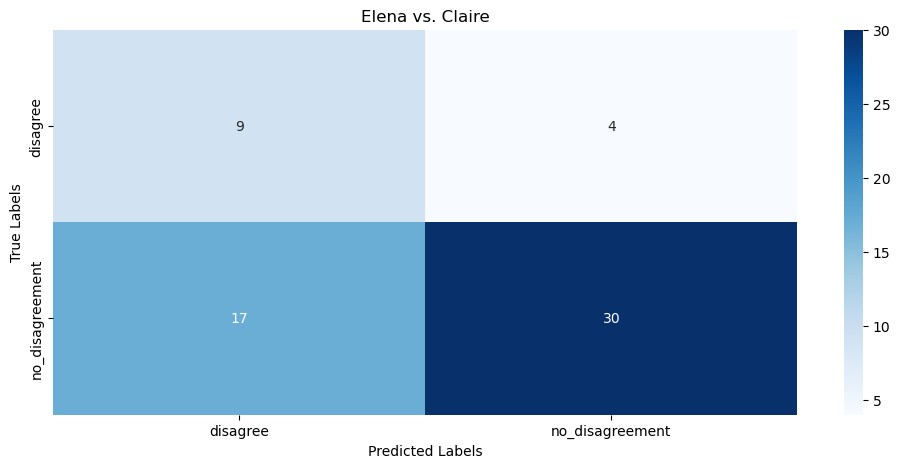

In [139]:
fig, axes = plt.subplots(1, 1, figsize=(12, 5))  


print_cm(
    axis=axes,
    df = df_2,
    true_col = "label_e_2",
    pred_col = "label_c_2",
    title='Elena vs. Claire'
)

label_c_2
no_disagreement    34
disagree           26
Name: count, dtype: int64
label_e_2
no_disagreement    47
disagree           13
Name: count, dtype: int64


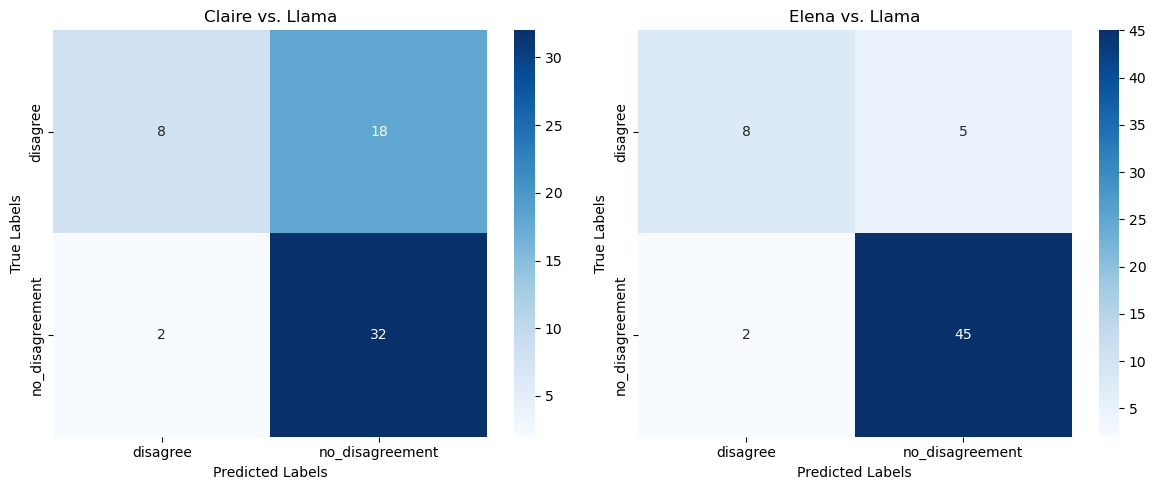

In [136]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
print_cm(
    axis=axes[0],
    df = df_2,
    true_col = "label_c_2",
    pred_col = "label_chat",
    title='Claire vs. Llama'
)

# Second matrix
print_cm(
    axis=axes[1],
    df = df_2,
    true_col = "label_e_2",
    pred_col = "label_chat",
    title='Elena vs. Llama'
)

plt.tight_layout()
plt.show()

label_e_3
neutral     20
disagree    17
agree       14
Name: count, dtype: int64


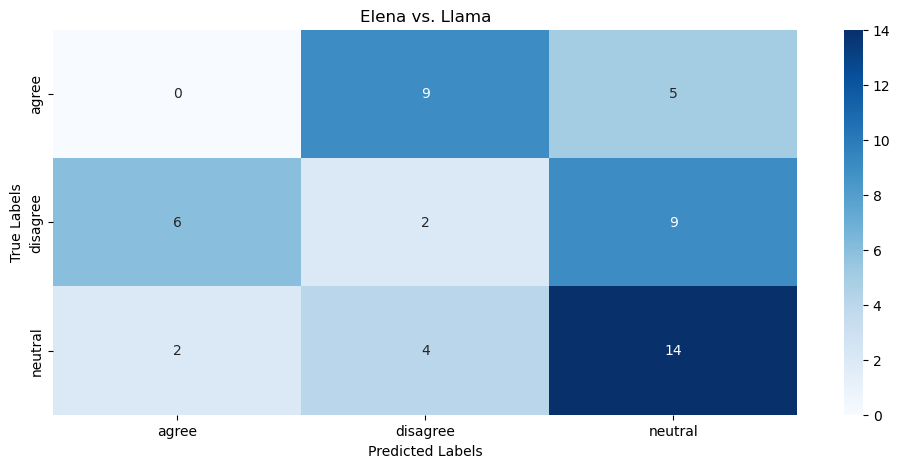

In [138]:
fig, axes = plt.subplots(1, 1, figsize=(12, 5))  

valid_df_3 = df_3[df_3['label_chat'].isin(valid_responses_3)]
print_cm(
    axis=axes,
    df = valid_df_3,
    true_col = "label_e_3",
    pred_col = "label_chat",
    title='Elena vs. Llama'
)

***

# **Error Investigation**

In [74]:
def get_errors(df, pred_col, true_col):

    errors = df[df[pred_col] != df[true_col]].reset_index(drop = True)

    return errors

errors_chat = get_errors(valid_chat, 'predicted_chat', 'label_2')
errors_plain = get_errors(valid_plain, 'predicted_plain', 'label_2')
errors_hybrid = get_errors(valid_hybrid, 'predicted_hybrid', 'label_2')

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns


def print_cm(df, pred_col):
    print(df['label_2'].value_counts())
    
    
    cm = confusion_matrix(df['label_2'], df[pred_col])
    labels = sorted(set(df['label_2']).union(set(df[pred_col])))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix: {pred_col}")
    
    plt.show()

label_2
disagree           203
no_disagreement     79
Name: count, dtype: int64


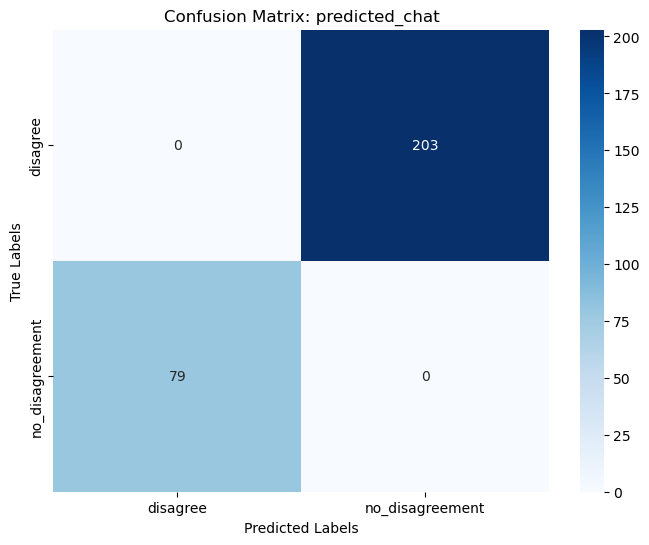

In [79]:
print_cm(errors_chat, 'predicted_chat')

**Findings**

* 203 / (282) = 0.7199 percent of the errors are predicted no_disagreement, when in fact it is disagreement

In [86]:
print((203 + 79))
print(203 / (203 + 79))

282
0.7198581560283688


label_2
disagree           232
no_disagreement     61
Name: count, dtype: int64


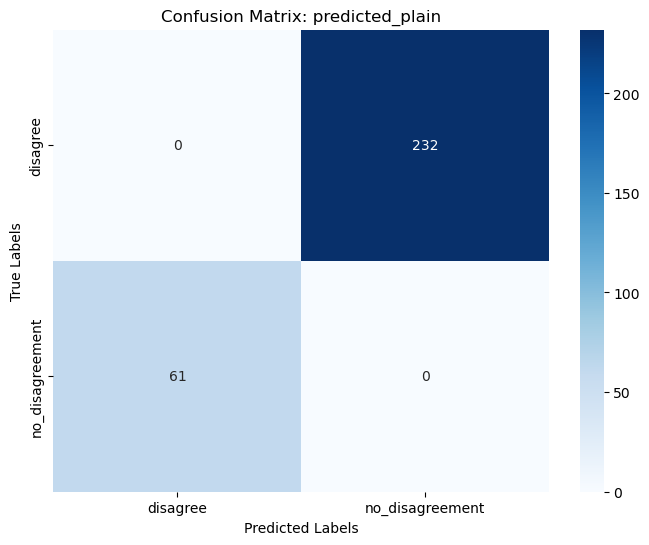

In [82]:
print_cm(errors_plain, 'predicted_plain')

label_2
disagree           152
no_disagreement    140
Name: count, dtype: int64


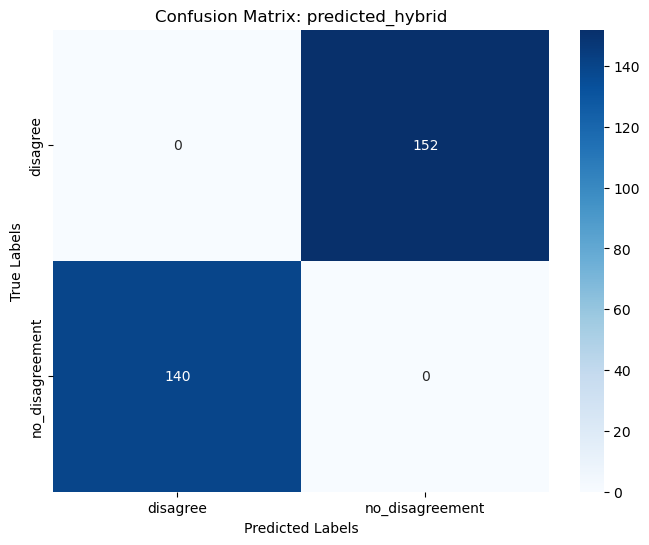

In [83]:
print_cm(errors_hybrid, 'predicted_hybrid')

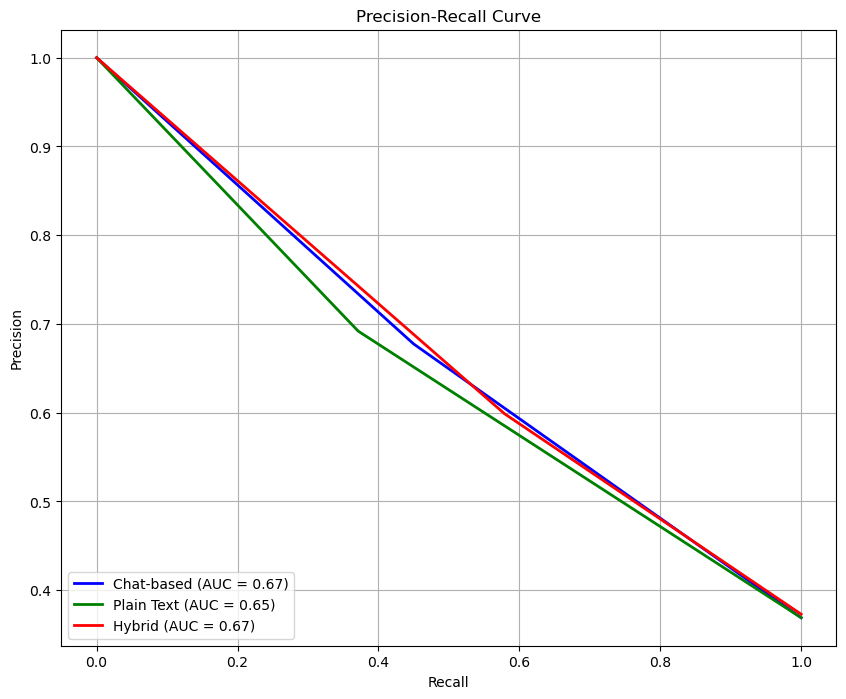

In [85]:

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

# Assuming you already have y_true as the true labels (0 = 'no_disagreement', 1 = 'disagree')

# Convert predictions to binary labels (0 and 1)
y_pred_chat = valid_chat['predicted_chat'].apply(lambda x: 1 if x == 'disagree' else 0)
y_pred_plain = valid_plain['predicted_plain'].apply(lambda x: 1 if x == 'disagree' else 0)
y_pred_hybrid = valid_hybrid['predicted_hybrid'].apply(lambda x: 1 if x == 'disagree' else 0)

y_true_chat = valid_chat['label_2'].apply(lambda x: 1 if x == 'disagree' else 0)
y_true_plain = valid_plain['label_2'].apply(lambda x: 1 if x == 'disagree' else 0)
y_true_hybrid = valid_hybrid['label_2'].apply(lambda x: 1 if x == 'disagree' else 0)


# Calculate Precision-Recall curve for each model
precision_chat, recall_chat, _ = precision_recall_curve(y_true_chat, y_pred_chat, pos_label=1)
precision_plain, recall_plain, _ = precision_recall_curve(y_true_plain, y_pred_plain, pos_label=1)
precision_hybrid, recall_hybrid, _ = precision_recall_curve(y_true_hybrid, y_pred_hybrid, pos_label=1)

# Calculate AUC for Precision-Recall curve
pr_auc_chat = auc(recall_chat, precision_chat)
pr_auc_plain = auc(recall_plain, precision_plain)
pr_auc_hybrid = auc(recall_hybrid, precision_hybrid)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))

plt.plot(recall_chat, precision_chat, color='blue', lw=2, label=f'Chat-based (AUC = {pr_auc_chat:.2f})')
plt.plot(recall_plain, precision_plain, color='green', lw=2, label=f'Plain Text (AUC = {pr_auc_plain:.2f})')
plt.plot(recall_hybrid, precision_hybrid, color='red', lw=2, label=f'Hybrid (AUC = {pr_auc_hybrid:.2f})')

# Labels and title
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)

# Show plot
plt.show()
